In [1]:
import numpy as np
from numpy.linalg import inv, det, multi_dot
import random
import math
from sklearn.datasets.samples_generator import make_blobs
from collections import Counter

In [2]:
X, y = make_blobs(n_samples=100, centers=3, n_features=2,random_state=100)

In [3]:
y

array([0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0,
       2, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2,
       2, 1, 1, 1, 1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       1, 0, 0, 2, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 1, 0, 2, 1, 2, 2, 1, 2, 1,
       1, 2, 1, 1, 0, 0, 1, 0])

In [4]:
X = np.asanyarray(X)
# dim of data
N, D = X.shape

Sig =  np.cov(X,rowvar = False)
mu_0 = np.mean(X, axis = 0)
Lambda_0 = np.identity(D)
Sig_inv = inv(Sig)
Lam_0_inv = inv(Lambda_0)

alpha = 1

In [5]:
def dMVN(x, mu, sig):
    d = x.shape[0]
    if d != mu.shape[0] or d != sig.shape[0]:
        print("Unmatched dimension")
        return None
    return (2*math.pi)**(-d/2) * (det(sig))**(-0.5) * math.exp(-0.5* multi_dot([np.transpose(x-mu),inv(sig),(x-mu)]))

In [27]:
zt = list(range(N))
length = []
for run in range(2000):
    #zt_new = list(range(N))
    for i in range(N):
        ext_cluster = zt[0:i]+zt[i+1:N]
        cluster_cnt = Counter(ext_cluster)
        p = {}
        # exisiting
        for c in cluster_cnt:
            n_c = cluster_cnt.get(c)
            A = (n_c+1)*Sig_inv+Lam_0_inv
            A_inv = inv(A)
            c_idx = np.where(np.asarray(zt) == c)[0]
            b = np.matmul(Sig_inv, np.sum([X[j] for j in c_idx], axis = 0))+np.matmul(Lam_0_inv,mu_0)
            sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
            mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
            f = dMVN(X[i], mu_i_star, sig_i_star)
            p[c] = n_c*f
        # new
        c = list(set(range(N))-set(ext_cluster))[0]
        A = Sig_inv+Lam_0_inv
        A_inv = inv(A)
        b = np.matmul(Lam_0_inv,mu_0)
        sig_i_star = inv(np.subtract(Sig_inv, multi_dot([Sig_inv, A_inv, Sig_inv])))
        mu_i_star = multi_dot([sig_i_star, Sig_inv, A_inv, b])
        f = dMVN(X[i], mu_i_star, sig_i_star)
        p[c] = alpha * f
        clusters = list(p.keys())
        zt[i] = random.choices(clusters, weights=[p.get(cl) for cl in clusters], k=1)[0]
    length.append(len(set(zt)))

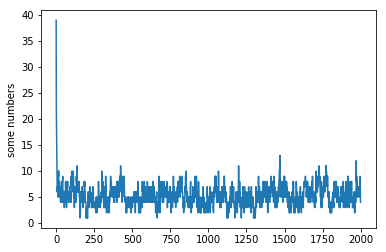

In [28]:
plt.plot(length)
plt.ylabel('some numbers')
plt.show()

In [32]:
np.mean(length)

5.2275

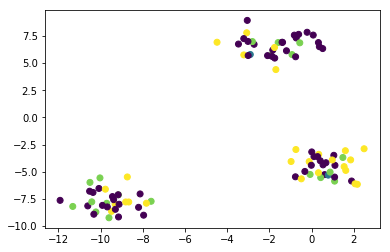

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=zt)